In [1]:
#hide
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns


import requests
import io
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-whitegrid')
## Set this to true to see legacy charts
debug=False

In [2]:
def load_timeseries(name):
    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
    url = f'{base_url}/time_series_covid19_{name}.csv'
    df = pd.read_csv(url, 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df
df_confirmed = load_timeseries('confirmed_global')

In [3]:
df_by_countries = df_confirmed.loc[(df_confirmed["country"] == "Portugal") | (df_confirmed["country"] == "Italy") | (df_confirmed["country"] == "Spain") | (df_confirmed["country"] == "US") | (df_confirmed["country"] == "Brazil")]

In [4]:
df_by_countries.drop(["state"], axis=1, inplace=True)

/Users/nunolourenco/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


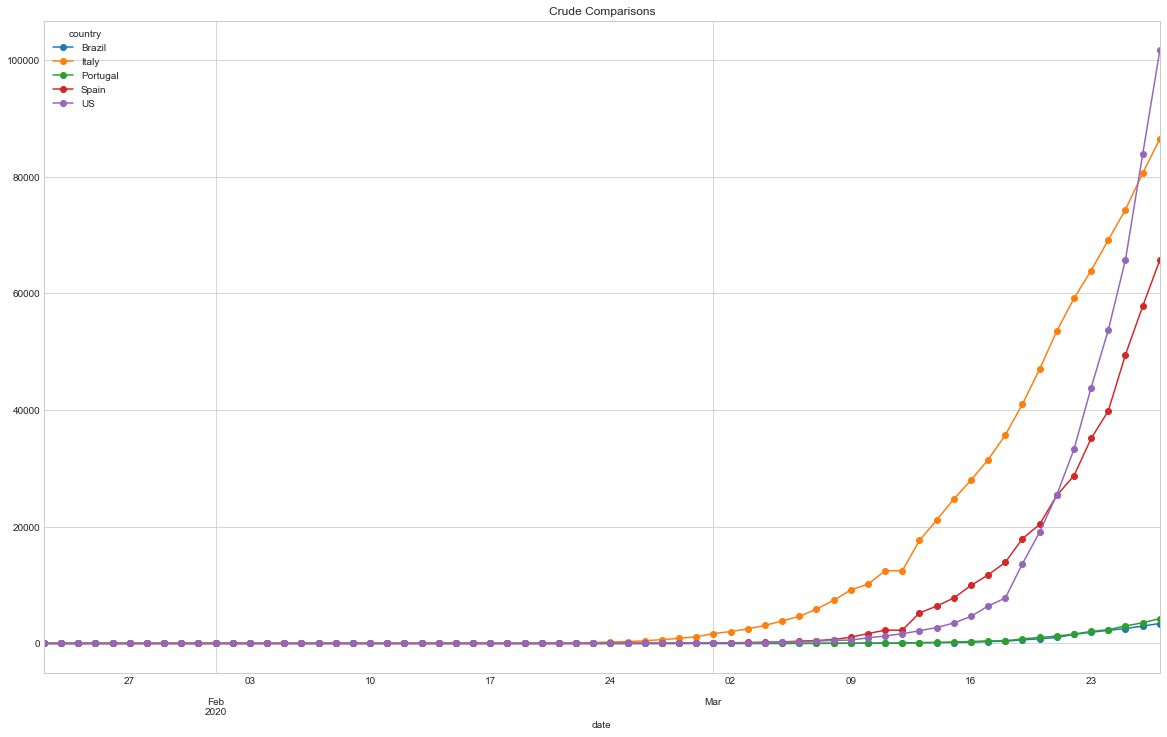

In [5]:
df_by_countries.pivot(columns="country", values="cases").plot(style='o-', title="Crude Comparisons", figsize=(20,12))

In [6]:
df_100 = df_by_countries[df_by_countries['cases'] > 100].pivot(columns="country", values="cases")
df_100 = df_100.reset_index()

In [7]:
df = df_100.apply(lambda x: pd.Series(x.dropna().values))

Text(0, 0.5, '#Cases')

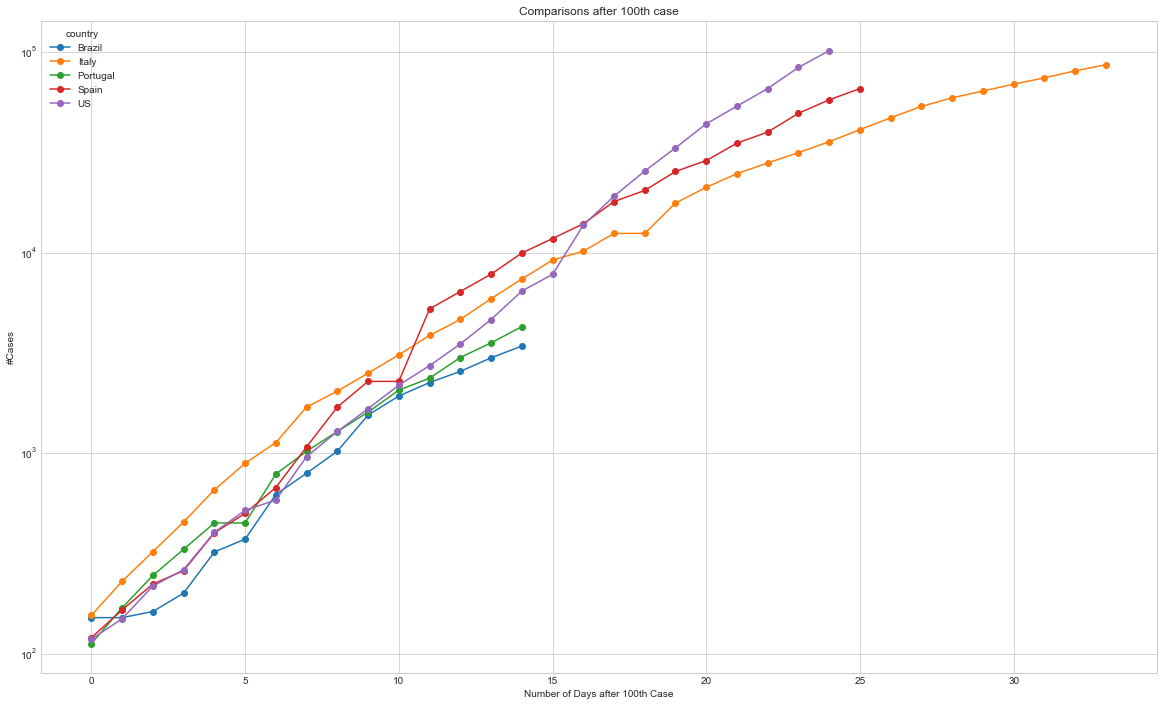

In [8]:
ax = df.drop("date", axis=1).plot(style='o-',title="Comparisons after 100th case", figsize=(20,12), logy=True)
ax.set_xlabel("Number of Days after 100th Case")
ax.set_ylabel("#Cases")

In [9]:
df_portugal = df_by_countries.pivot(columns="country", values="cases")['Portugal']
df_portugal = df_portugal[df_portugal>0].to_frame()

In [10]:
def logistic_prediction(data):
    number_of_predictions = data.size
    seed = 4.66
    r = 0.33
    MaxNumberOfCases = 100000
    predicted = np.zeros(number_of_predictions)
    predicted[0] = seed
    for i in range(1, predicted.size):
        predicted[i] = predicted[i - 1] + predicted[i - 1] * r * (1 - (predicted[i - 1] / MaxNumberOfCases))
    return predicted

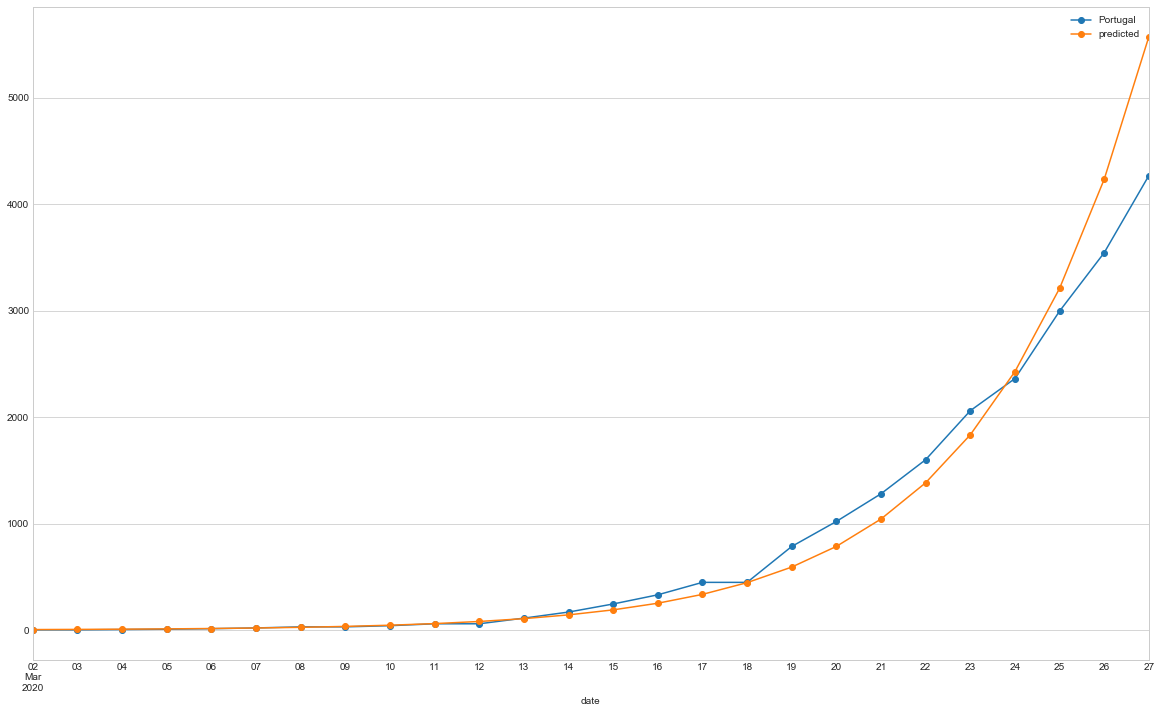

In [11]:
df_portugal['predicted'] = logistic_prediction(df_portugal['Portugal'])
df_portugal.plot(figsize=(20,12), style="o-")

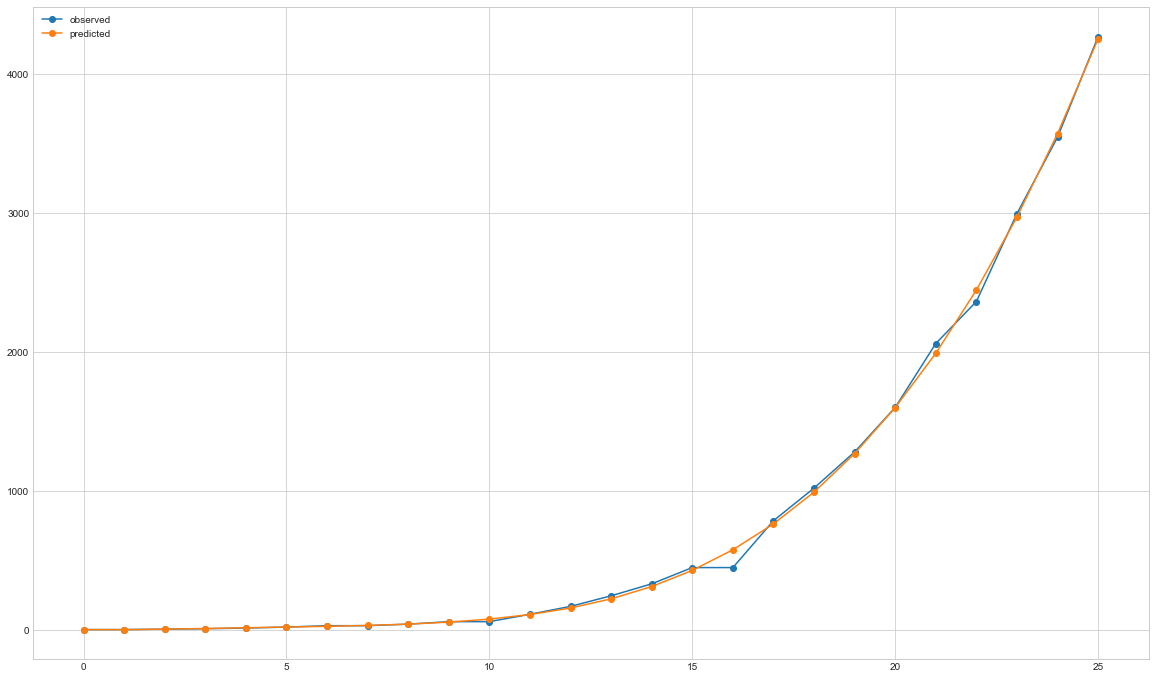

In [17]:
values = df_portugal['Portugal'].values
x_values = np.arange(values.size)
poly = np.polyfit(np.arange(values.size), values,5)
predicted = np.polyval(poly, np.arange(values.size))
plt.figure(figsize=(20,12))
plt.plot(x_values, values, 'o-',label="observed")
plt.plot(x_values, predicted,'o-', label="predicted",)
plt.legend()

In [13]:
previous = df_portugal['Portugal'].values
next_day = df_portugal['Portugal'].values
increased = (next_day[1:] - previous[:-1]) / previous[:-1]

Text(0, 0.5, 'Percentage')

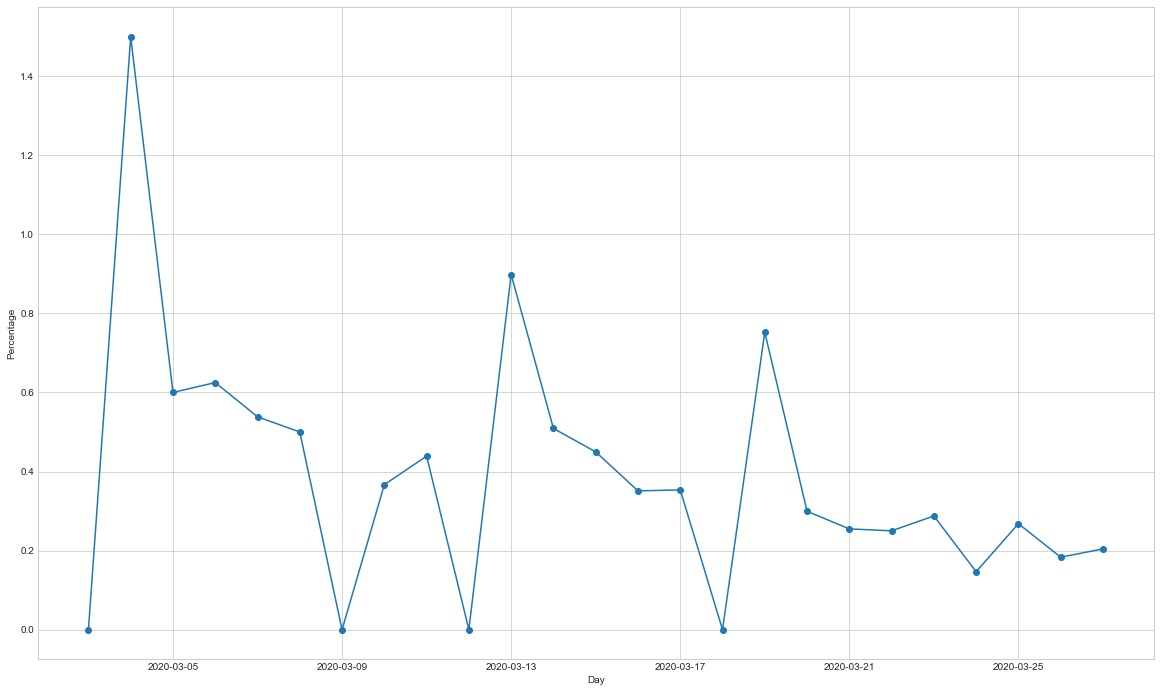

In [26]:
plt.plot(df_portugal['Portugal'].index[1:], increased, 'o-');
plt.xlabel("Day")
plt.ylabel('Percentage')


In [15]:
predicted

array([1.55139138e+00, 1.44757613e+00, 4.82908645e+00, 9.71330497e+00,
       1.49250024e+01, 2.00502868e+01, 2.53905522e+01, 3.19164283e+01,
       4.12217291e+01, 5.54774021e+01, 7.73854774e+01, 1.10133017e+02,
       1.57346063e+02, 2.23043588e+02, 3.11591444e+02, 4.27656309e+02,
       5.76159641e+02, 7.62231621e+02, 9.91165108e+02, 1.26836958e+03,
       1.59932510e+03, 1.98953624e+03, 2.44448606e+03, 2.96959001e+03,
       3.57014995e+03, 4.25130803e+03])

In [16]:
df_portugal.reindex(df_portugal.index.union(np.array([df_portugal.index[-1] + np.timedelta64(1, 'D')])))

,Portugal,predicted
2020-03-02 00:00:00,2.0,4.660000
2020-03-03 00:00:00,2.0,6.197728
2020-03-04 00:00:00,5.0,8.242852
2020-03-05 00:00:00,8.0,10.962769
2020-03-06 00:00:00,13.0,14.580086
2020-03-07 00:00:00,20.0,19.390813
2020-03-08 00:00:00,30.0,25.788540
2020-03-09 00:00:00,30.0,34.296564
2020-03-10 00:00:00,41.0,45.610548
2020-03-11 00:00:00,59.0,60.655164
